# Storm Detection

## Setup

### Imports

In [1]:
%matplotlib inline

import os
import time
import copy
import random
import numpy as np
from matplotlib import pyplot as plt

import cv2

import torch
from torchvision import datasets, models, transforms
from sklearn.metrics import f1_score, confusion_matrix

from PIL import Image

import seaborn as sn
import pandas as pd

from cf_matrix import make_confusion_matrix

### Create Constants
**Note:** This Notebook must be run in a UC Lab machine as it needs access to the CSSE Research drive. You also may need to gain read access from Richard to the drive.

In [2]:
# Preproccesing
RESEARCH_DIR = '/csse/research/antarctica_seals/scott_base/2018-19/cropped'  # For now, only using 2018 - 2019
CROPS_PER_IMG = 5
OUT_DIR = 'data/all'
CROP_SIZE = 500  # px

# Training
DATA_DIR = "./data"  # ImageFolder structure
MODEL_NAME = "resnet"  # From [resnet, alexnet, vgg, squeezenet, densenet, inception]
NUM_CLASSES = 2
BATCH_SIZE = 8
NUM_EPOCHS = 15
# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
FEATURE_EXTRACT = True
INPUT_SIZE = 224

### Intervals

In [3]:
example = {'Camera Identifier': [('Prefix 1', ['img_id start', 'img_id end']),
                                 ('Prefix 2', ['img_id start', 'img_id end'])]}
# ('C', []),
all_storms = {'A': [('F', [(309, 312), (340, 344), (346, 347), (357, 358), (1516, 1517), (413, 414), (1522, 1561)]),
                    ('E', [(7363, 7363), (7365, 7365), (7367, 7369), (7372, 7376), (7380, 7389), (7391, 7394),
                           (7397, 7400), (9673, 9682), (9683, 9684)]),
                    ('C', [(4581, 4584), (4586, 4586)]),
                    ('D', [(6555, 6598)])],
              'B': [('C', [(1500, 1500), (1939, 1940), (1943, 1943), (2324, 2324)]),
                    ('D', [(3920, 3924)]),
                    ('E', [(4723, 4740), (4742, 4756), (4760, 4766), (4768, 4768), (4809, 4809), (4820, 4820),
                           (4824, 4848), (6104, 6104), (6106, 6106), (7036, 7047), (7050, 7051), (7053, 7053)]),
                    ('F', [(7580, 7580), (7615, 7615), (7701, 7703), (7731, 7731), (7736, 7736), (7738, 7738),
                           (7743, 7744), (7771, 7776), (7779, 7780), (8307, 8307), 
                           (8749, 8751), (8753, 8759), (8874, 8880), (8881, 8893), (8927, 8927)])],
              'C': [('C', [(1060, 1063), (1065, 1065), (1446, 1446), (1493, 1495), (1497, 1499), (1556, 1557), (1561, 1561)]),
                    ('D', [(3045, 3045)]),
                    ('E', [(3843, 3885), (3887, 3889), (6153, 6167), (6173, 6173)]),
                    ('F', [(6623, 6630), (6651, 6661)])]}

all_clears = {'A': [('C', [(4611, 4612), (4620, 4621), (4623, 4623), (4736, 4737), (4740, 4740), (4749, 4750),
                           (4769, 4769), (5168, 5168), (5171, 5171)]),
                    ('D', [(5483, 5484), (5628, 5628), (5779, 5779), (6044, 6044), (6052, 6052), (6184, 6185),
                           (6615, 6615)]),
                    ('E', [(8875, 8875), (8878, 8879), (9716, 9716), (9718, 9718), (9721, 9722), (9725, 9725),
                           (9728, 9729), (9742, 9742), (9744, 9744), (9749, 9750), (9857, 9860), (9862, 9868),
                           (9870, 9870), (9872, 9873), (9875, 9875), (9884, 9884), (9887, 9891), (9893, 9893),
                           (9895, 9895)]),
                    ('F', [(573, 573), (575, 575), (577, 577), (668, 669), (803, 805), (917, 917), (974, 974),
                           (1271, 1272), (1354, 1354), (1419, 1419), (1422, 1422), (1613, 1613), (1615, 1617),
                           (1697, 1697), (1774, 1774), (1853, 1853), (1855, 1857), (1920, 1923), (1926, 1926),
                           (1928, 1929), (1993, 1993)]),
                    ('G', [(2062, 2064), (2175, 2175), (2177, 2179), (2184, 2190), (2192, 2192), (2194, 2194),
                           (2297, 2297), (2301, 2302), (2304, 2315), (2317, 2317), (2498, 2500), (2575, 2575),
                           (2647, 2648), (2848, 2850), (2935, 2935), (3071, 3072), (3168, 3168), (3199, 3201),
                           (3203, 3205), (3207, 3211), (3214, 3216), (3218, 3226), (3294, 3294), (3445, 3446),
                           (3507, 3508), (3581, 3581)]),
                    ('H', [(3635, 3636)]),
                   ],
              'B': [('A', [(257, 257), (263, 263), (277, 277), (281, 281), (286, 286), (288, 291), (295, 301),
                           (303, 303), (308, 310), (315, 316)]),
                    ('B', [(404, 404), (406, 406), (414, 420), (429, 454), (414, 420), (429, 454), (474, 480),
                           (525, 526), (530, 532), (539, 539), (545, 577)]),
                    ('E', [(4404, 4404), (4438, 4438), (4443, 4443), (4560, 4561), (4587, 4587), (4698, 4698),
                           (4957, 4957), (4960, 4960), (5267, 5268), (5275, 5275), (5284, 5285), (5306, 5306),
                           (5450, 5450), (5455, 5455), (5584, 5584), (5590, 5590), (5735, 5735), (5753, 5754),
                           (5852, 5852), (5869, 5870), (5872, 5872), (5904, 5904), (6006, 6006), (6042, 6042),
                           (6133, 6134)]),
                    ('F', [(9332, 9333), (9335, 9337)]),
                    ('D', [(3996, 3996), (3999, 4002), (4008, 4008), (4291, 4291), (4314, 4314), (4317, 4317)]),
                    ('G', [(51, 54)])],
              'C': [('D', [(1761, 1761), (1764, 1764), (2018, 2018), (2020, 2020), (2022, 2022), (2024, 2026),
                           (2029, 2029), (2031, 2031), (2033, 2035), (2038, 2039), (2041, 2044), (2046, 2048),
                           (2142, 2142), (2146, 2147), (2149, 2150), (2204, 2204), (2206, 2206), (2224, 2224),
                           (2226, 2226), (2274, 2274), (2277, 2277), (2279, 2279), (2282, 2283), (2361, 2362),
                           (2364, 2364), (2372, 2372), (2376, 2376), (2441, 2442), (2479, 2482), (2484, 2484),
                           (2486, 2490), (2567, 2567), (2570, 2570), (2575, 2575), (2584, 2586), (2588, 2588), 
                           (2590, 2590), (2593, 2593), (2599, 2599), (2618, 2619), (2622, 2622), (2625, 2626),
                           (2629, 2629), (2631, 2631), (2806, 2806), (2816, 2816), (2825, 2826), (2879, 2879),
                           (2951, 2951), (2953, 2954), (2957, 2958), (2961, 2961), (3009, 3010), (3012, 3015),
                           (3032, 3032), (3069, 3070), (3072, 3073), (3171, 3171), (3174, 3178), (3246, 3246),
                           (3255, 3255), (3257, 3257), (3400, 3400), (3467, 3467)]),
                    ('E', [(3517, 3518), (3706, 3706), (3796, 3796), (4260, 4261), (4275, 4275), (4277, 4280),
                           (4409, 4409), (4421, 4421), (4575, 4575), (4996, 4996), (5264, 5266), (5268, 5272),
                           (5278, 5278), (5280, 5280), (5285, 5285), (5710, 5710), (5982, 5983), (5994, 5994),
                           (5996, 5996), (6145, 6145)]),
                    ('F', [(6998, 6999), (7048, 7049), (7912, 7913), (7973, 7973), (8071, 8071), (8129, 8129),
                           (8133, 8133), (8135, 8136), (8140, 8140), (8201, 8202), (8205, 8205)]),
                    ('G', [(9782, 9782)]),]}

### Helper Methods

In [4]:
# TODO make a class that holds all of this info with a to_string that has the correct filename
def leading_zeros(number, total_amount=4):
    count = total_amount - len(str(number))
    return '0' * count if count >= 0 else ''

def show(img, title='', scale=3, rgb_convert=True):
    if img is None:
        print(f'{title if title else "Image"} does not exist')
        return
    h, w = img.shape[:2]
    plt.figure(figsize = (w/h*scale, scale))
    plt.title(title)
    if rgb_convert:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
def rand_crop(img, size):
    y, x = (random.randint(0, ax - size) for ax in img.shape[:2])
    cropped_image = img[y:y+size, x:x+size]
    return cropped_image

def create_and_save_crops(is_storm):
    data = all_storms if is_storm else all_clears
    total_count = 0
    for cam_id, storms in data.items():
        cam_count = 0  # Count of storm/clear images per Camera
        for prefix, intervals in storms:
            for start, end in intervals:
                assert start <= end
                cam_count += (end - start + 1)
                for img_id in range(start, end+1):
                    # For each image of a storm/clear
                    filename = f'{prefix}{leading_zeros(img_id)}{img_id}'
                    path = f'{RESEARCH_DIR}/Camera{cam_id}/{filename}.jpg'
                    img = cv2.imread(path)
                    if img is None:
                        continue
                    for i in range(CROPS_PER_IMG):
                        cropped_image = rand_crop(img, CROP_SIZE)
                        cv2.imwrite(f'{OUT_DIR}/{"storm" if is_storm else "clear"}/{cam_id}_{filename}_{i+1}.jpg', cropped_image)
        total_count += (cam_count * CROPS_PER_IMG)

        print(f'{cam_count} images of storm/clear from Camera {cam_id}')
        print(f"{cam_count * CROPS_PER_IMG} total augmentations saved to '{OUT_DIR}/{'storm' if is_storm else 'clear'}'\n")
    print(f'Total augmentation count: {total_count}\n')

### Example Images

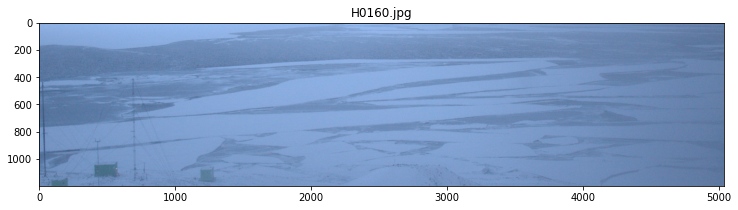

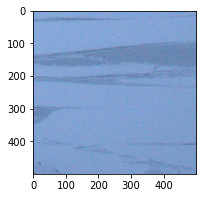

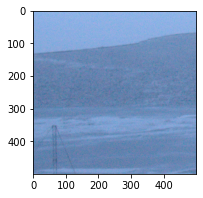

In [5]:
camera_id = 'C'

img_dir = f'{RESEARCH_DIR}/Camera{camera_id}'
filename = random.choice(os.listdir(img_dir))
path = os.path.join(img_dir, filename)

img = cv2.imread(path)
show(img, title=filename)
for _ in range(2):
    cropped_image = rand_crop(img, CROP_SIZE)
    show(cropped_image)

## Preperation

### Print Dataset Size

In [8]:
def count(data):
    total_count = 0
    cam_counts = {}
    for cam_id, storms in data.items():
        cam_counts[cam_id] = 0
        cam_count = 0  # Count of storm/clear images per Camera
        for _, intervals in storms:
            for start, end in intervals:
                cam_counts[cam_id] += (end - start + 1)
    return cam_counts

all_storms_counts = count(all_storms)
print(f'Total Storm Images: {sum(all_storms_counts.values())}')
print('\n'.join([f'Camera {k}: {v}' for k, v in all_storms_counts.items()]))

all_clears_counts = count(all_clears)
print(f'\nTotal Clear Images: {sum(all_clears_counts.values())}')
print('\n'.join([f'Camera {k}: {v}' for k, v in all_clears_counts.items()]))

Total Storm Images: 388
Camera A: 146
Camera B: 145
Camera C: 97

Total Clear Images: 505
Camera A: 168
Camera B: 185
Camera C: 152


### Create Augmentations
#### Remove existing data

In [7]:
!find data/ ! -name '.*' ! -type d -exec rm -- {} +

#### Create new data

In [9]:
create_and_save_crops(is_storm=True)
create_and_save_crops(is_storm=False)

146 images of storm/clear from Camera A
730 total augmentations saved to 'data/all/storm'

145 images of storm/clear from Camera B
725 total augmentations saved to 'data/all/storm'

97 images of storm/clear from Camera C
485 total augmentations saved to 'data/all/storm'

Total augmentation count: 1940

168 images of storm/clear from Camera A
840 total augmentations saved to 'data/all/clear'

185 images of storm/clear from Camera B
925 total augmentations saved to 'data/all/clear'

152 images of storm/clear from Camera C
760 total augmentations saved to 'data/all/clear'

Total augmentation count: 2525



### Split Data
Split data into Training Validation and Testing sets.

In [11]:
!ls data/all/storm | wc -l | xargs -i echo 'Total Storm Images: {}'
!ls data/all/storm | wc -l | xargs -i echo  '{} * 0.70' | bc | xargs -i echo '70%: {}'
!ls data/all/storm | wc -l | xargs -i echo  '{} * 0.15' | bc | xargs -i echo '15%: {}'

!echo
!ls data/all/clear | wc -l | xargs -i echo 'Total Clear Images: {}'
!ls data/all/clear | wc -l | xargs -i echo  '{} * 0.70' | bc | xargs -i echo '70%: {}'
!ls data/all/clear | wc -l | xargs -i echo  '{} * 0.15' | bc | xargs -i echo '15%: {}'

Total Storm Images: 1940
70%: 1358.00
15%: 291.00

Total Clear Images: 2360
70%: 1652.00
15%: 354.00


In [12]:
!cd data && ls all/storm | shuf -n 1358 | xargs -i mv all/storm/{} train/storm
!cd data && ls all/storm | shuf -n 291 | xargs -i mv all/storm/{} val/storm
!cd data && ls all/storm | shuf -n 291 | xargs -i mv all/storm/{} test/storm

!cd data && ls all/clear | shuf -n 1652 | xargs -i mv all/clear/{} train/clear
!cd data && ls all/clear | shuf -n 354 | xargs -i mv all/clear/{} val/clear
!cd data && ls all/clear | shuf -n 354 | xargs -i mv all/clear/{} test/clear

## Train Model

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    score_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0.0
    best_score = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            # https://discuss.pytorch.org/t/calculating-f1-score-over-batched-data/83348/2
            f1_labels = []
            f1_preds = []

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # Calculate f1-score
                f1_preds.append(preds.cpu())
                f1_labels.append(labels.cpu().data)

            f1_preds = np.concatenate(f1_preds)
            f1_labels = np.concatenate(f1_labels)
            # epoch_f1 = f1_score(labels.cpu().data, preds.cpu())
            epoch_f1 = f1_score(f1_labels, f1_preds)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f} F1: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_f1))

            # deep copy the model
            if phase == 'val':
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                # Score to optimise
                # score = epoch_acc
                score = epoch_f1
                if score > best_score:
                    best_score = score
                    best_model_wts = copy.deepcopy(model.state_dict())
                score_history.append((best_score, best_f1))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_score))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, score_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

            
def initialize_model(use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.

    model = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model, FEATURE_EXTRACT)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
    
    return model

In [14]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
# Initialize the model for this run
model = initialize_model(use_pretrained=True)

# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if FEATURE_EXTRACT:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


### Start Training & Graph Progress

Epoch 0/14
----------
train Loss: 0.3000 Acc: 0.8708 F1: 0.8556
val Loss: 0.1001 Acc: 0.9643 F1: 0.9594

Epoch 1/14
----------
train Loss: 0.2479 Acc: 0.9063 F1: 0.8956
val Loss: 0.1098 Acc: 0.9643 F1: 0.9608

Epoch 2/14
----------
train Loss: 0.2396 Acc: 0.9037 F1: 0.8930
val Loss: 0.0921 Acc: 0.9659 F1: 0.9610

Epoch 3/14
----------
train Loss: 0.2268 Acc: 0.9156 F1: 0.9067
val Loss: 0.0878 Acc: 0.9752 F1: 0.9719

Epoch 4/14
----------
train Loss: 0.2452 Acc: 0.9096 F1: 0.8999
val Loss: 0.0826 Acc: 0.9752 F1: 0.9719

Epoch 5/14
----------
train Loss: 0.2117 Acc: 0.9159 F1: 0.9070
val Loss: 0.0784 Acc: 0.9783 F1: 0.9754

Epoch 6/14
----------
train Loss: 0.2253 Acc: 0.9143 F1: 0.9048
val Loss: 0.0723 Acc: 0.9752 F1: 0.9726

Epoch 7/14
----------
train Loss: 0.2294 Acc: 0.9113 F1: 0.9013
val Loss: 0.0717 Acc: 0.9767 F1: 0.9743

Epoch 8/14
----------
train Loss: 0.2313 Acc: 0.9136 F1: 0.9038
val Loss: 0.1053 Acc: 0.9674 F1: 0.9628

Epoch 9/14
----------
train Loss: 0.2278 Acc: 0.9123 F1

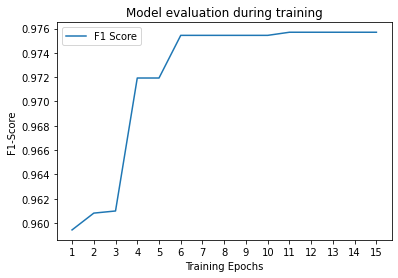

In [15]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=NUM_EPOCHS, is_inception=(MODEL_NAME=="inception"))

# Plot improvement
acc_hist, f1_hist = zip(*hist)
plt.title("Model evaluation during training")
plt.xlabel("Training Epochs")
plt.ylabel("F1-Score")
# plt.plot(range(1,NUM_EPOCHS+1),acc_hist,label="Accuracy")
plt.plot(range(1,NUM_EPOCHS+1),f1_hist,label="F1 Score")
plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
plt.legend()
plt.show()

### Save Model

In [159]:
torch.save(model.state_dict(), './storm_model.pt')

### Load Model

In [16]:
model = initialize_model(use_pretrained=True)
model = model.to(device)
model.load_state_dict(torch.load('./storm_model.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Evaluation

### Accuracy

In [17]:
correct = 0
total = 0
classes = ['clear', 'storm']
for _class in classes:
    data_dir = 'data/test/' + _class
    files = os.listdir(data_dir)
    total += len(files)
    for file in files:  
        path = os.path.join(data_dir, file)    

        img = Image.open(path)

        img_t = data_transforms['val'](img)
        batch_t = torch.unsqueeze(img_t, 0)
        batch_t = batch_t.to(device)

        model.eval()

        out = model(batch_t)

        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        _, index = torch.max(out, 1)

        if classes[index[0]] == _class:
            correct += 1
#         else:
#             show(np.asarray(img), scale=2, rgb_convert=False, title=f'{file.split(".")[0]} {classes[index[0]]} {percentage[index[0]].item():.2f}%')

print(f'{correct / total * 100:.2f}% Accuracy')

97.21% Accuracy


### Test Random Image

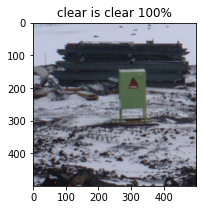

In [19]:
classes = ['clear', 'storm']
data_dir = 'data/test'
_class = random.choice(classes)
path = f'{data_dir}/{_class}/'
file = random.choice(os.listdir(path))
path += file
img = Image.open(path)

img_t = data_transforms['val'](img)
batch_t = torch.unsqueeze(img_t, 0)
batch_t = batch_t.to(device)

model.eval()
out = model(batch_t)

percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, index = torch.max(out, 1)

show(np.asarray(img), rgb_convert=False, title=f'{_class} is {classes[index]} {percentage[index[0]].item():.0f}%')

### Confusion Matrix

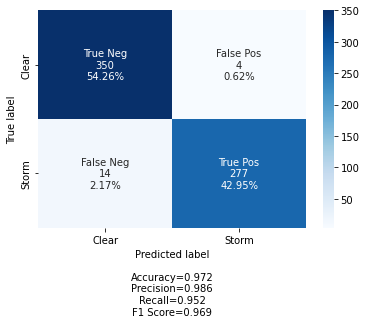

In [20]:
y_pred = []
y_true = []

model.eval()
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    output = model(inputs)
    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ['Clear', 'Storm']

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
make_confusion_matrix(cf_matrix, 
                      group_names=group_names,
                      categories=classes)